In [1]:
import datetime as dtm
import requests
import pandas as pd
import time
import os
import numpy as np
import pickle
from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance
import matplotlib.pyplot as plt
import src.data_retriever as intrinio
%matplotlib inline

In [2]:
datefrom = dtm.datetime(2012, 1, 1)
dateto = dtm.datetime(2019, 1, 1)

In [3]:
#DOW 30
stock_names = ['AAPL', 'CSCO', 'WMT', 'MCD', 'GS', 'AXP', 'BA', 'KO', 'V', 'WMT', 'UNH']
# stock_names = ['AAPL']

In [4]:
stocks_filename = 'stocks.csv'
if os.path.isfile(stocks_filename):
    stocks = pd.read_csv(stocks_filename)
    stocks['date'] = pd.to_datetime(stocks['date'], format="%Y-%m-%d")
else:
    stocks = intrinio.get_stocks_data(stock_names, datefrom, dateto)
    stocks.to_csv(stocks_filename, index_label='id', columns=stocks.columns)

### Подготовка к обучению

In [5]:
train_datefrom = dtm.datetime(2017, 1, 1)
train_dateto = dtm.datetime(2018, 6, 1)

valid_datefrom = train_dateto
valid_dateto = dtm.datetime(2019, 1, 1)

In [6]:
data = stocks.drop(0).reset_index(drop=True)
data['date'] = data['date'].map(lambda x: x.timestamp())

In [7]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

#to_normalize = ['volume_prev1', 'ebitda']
data['date_norm'] = MinMaxScaler().fit_transform(data['date'].as_matrix().reshape(-1, 1))
#data['volume_prev1'] = MinMaxScaler().fit_transform(data['volume_prev1'].as_matrix().reshape(-1, 1))
#data['ebitda'] = MinMaxScaler().fit_transform(data['ebitda'].as_matrix().reshape(-1, 1))
data['stock_name'] = LabelEncoder().fit_transform(data['stock_name'].as_matrix().reshape(-1, 1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
train_data = data[data['date'] <= train_dateto.timestamp()]
X_train = train_data.drop(['date','close','adj_close', 'volume'],axis=1)
print(len(X_train))
Y_train_regr = train_data['close']
Y_train_classify = train_data['close'] > train_data['open']

17753


In [9]:
valid_data = data[data['date'] > valid_datefrom.timestamp()]
# valid_data = valid_data.query('(stock_name == 0)')
X_valid = valid_data.drop(['date','close','adj_close', 'volume'],axis=1)
print(len(X_valid))
Y_valid_regr = valid_data['close']
Y_valid_classify =valid_data['close'] > valid_data['open']

1605


In [10]:
ts = time.time()

filename = 'xgboost_regr.pickle.dat'
if os.path.isfile(filename) and False:
    model_regr = pickle.load(open(filename, "rb"))
else:
    model_regr = XGBRegressor(
        max_depth=8,
        n_estimators=1000,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=0.3,    
        seed=42)

    model_regr.fit(
        X_train, 
        Y_train_regr, 
        eval_set=[(X_train, Y_train_regr), (X_valid, Y_valid_regr)], 
        eval_metric='mae',
        verbose=True, 
        early_stopping_rounds = 10)
    pickle.dump(model_regr, open(filename, "wb"))
    
time.time() - ts

[0]	validation_0-mae:102.906	validation_1-mae:138.604
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:92.6218	validation_1-mae:123.48
[2]	validation_0-mae:83.3776	validation_1-mae:110.519
[3]	validation_0-mae:75.0547	validation_1-mae:99.6729
[4]	validation_0-mae:67.5615	validation_1-mae:89.9014
[5]	validation_0-mae:60.8105	validation_1-mae:81.0713
[6]	validation_0-mae:54.7316	validation_1-mae:72.2785
[7]	validation_0-mae:49.2737	validation_1-mae:65.0705
[8]	validation_0-mae:44.3584	validation_1-mae:58.5419
[9]	validation_0-mae:39.9346	validation_1-mae:52.6515
[10]	validation_0-mae:35.9529	validation_1-mae:47.3308
[11]	validation_0-mae:32.3677	validation_1-mae:42.5407
[12]	validation_0-mae:29.1403	validation_1-mae:38.2335
[13]	validation_0-mae:26.2371	validation_1-mae:34.3956
[14]	validation_0-mae:23.6217	validation_1-mae:30.9117
[15]	validation_0-mae:21.2661

15.061262607574463

In [14]:
ts = time.time()

filename = 'xgboost_classif.pickle.dat'
if os.path.isfile(filename) and False:
    model_class = pickle.load(open(filename, "rb"))
else:
    model_class = XGBClassifier(  
        max_depth=8,
        n_estimators=1000,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=0.3,    
        seed=42)

    model_class.fit(
        X_train, 
        Y_train_classify, 
        eval_set=[(X_train, Y_train_classify), (X_valid, Y_valid_classify)], 
        verbose=True, 
        
        eval_metric='error',
        early_stopping_rounds = 10)
    pickle.dump(model_class, open(filename, "wb"))
    
time.time() - ts

[0]	validation_0-error:0.417451	validation_1-error:0.436137
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.395201	validation_1-error:0.411838
[2]	validation_0-error:0.381569	validation_1-error:0.401869
[3]	validation_0-error:0.381175	validation_1-error:0.393769
[4]	validation_0-error:0.376669	validation_1-error:0.389408
[5]	validation_0-error:0.37205	validation_1-error:0.401869
[6]	validation_0-error:0.369909	validation_1-error:0.391277
[7]	validation_0-error:0.367769	validation_1-error:0.386916
[8]	validation_0-error:0.363375	validation_1-error:0.383801
[9]	validation_0-error:0.359995	validation_1-error:0.381931
[10]	validation_0-error:0.35977	validation_1-error:0.380062
[11]	validation_0-error:0.359432	validation_1-error:0.386916
[12]	validation_0-error:0.357123	validation_1-error:0.375701
[13]	validation_0-error:0.356954	validation_1-error:0.3781

7.203773021697998

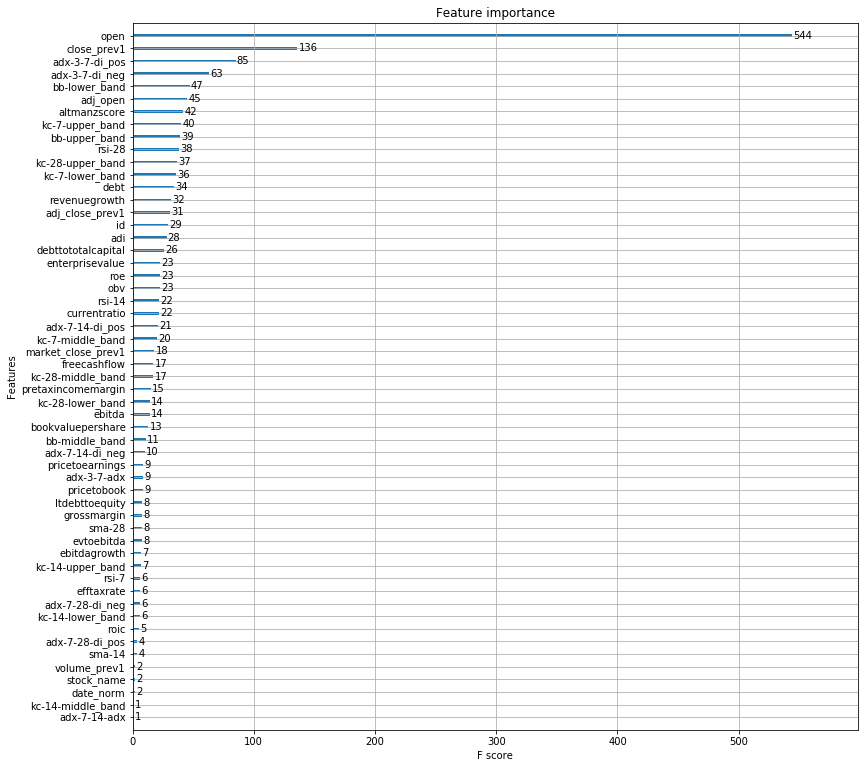

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(13,13))
plot_importance(booster=model_regr, ax=ax)

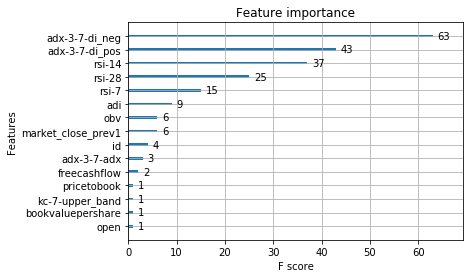

In [13]:
plot_importance(booster=model_class)